error in estimating w: [ 0.12957335 -0.2279551 ]
error in estimating b: [0.26196575]
1.16098 sec


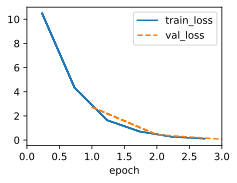

In [1]:
import time
from mxnet import autograd, context, gluon, image, init, npx, np
from mxnet.gluon import nn
import inspect
import collections
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from IPython import display
import random

npx.set_np()

class HyperParameters: #@save
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented
        
    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.
    
        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
#         ident = (frame.f_code.co_filename, frame.f_lineno)
#         print(frame)
#         print(ident)
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

            
def add_to_class(Class):  #@save
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

def cpu():
    """Defined in :numref:`sec_use_gpu`"""
    return npx.cpu()
def gpu(i=0):
    """Defined in :numref:`sec_use_gpu`"""
    return npx.gpu(i)

def snum_gpus():
    """Defined in :numref:`sec_use_gpu`"""
    return npx.num_gpus()

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().
    Defined in :numref:`sec_use_gpu`"""
    if snum_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists.
    Defined in :numref:`sec_use_gpu`"""
    return [gpu(i) for i in range(snum_gpus())]

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.
    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')


class ProgressBoard(HyperParameters):  #@save
    """Plot data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented
    
    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        use_svg_display()
        
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)
        

class Module(nn.Block, HyperParameters):  #@save
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.asnumpy(), (
            'train_' if train else 'val_') + key, every_n=int(n))
        
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError
        
    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        params = self.parameters()
        if isinstance(params, list):
            return SGD(params, self.lr)
        return gluon.Trainer(params, 'sgd', {'learning_rate': self.lr})

    def get_scratch_params(self):
        """Defined in :numref:`sec_classification`"""
        params = []
        for attr in dir(self):
            a = getattr(self, attr)
            if isinstance(a, np.ndarray):
                params.append(a)
            if isinstance(a, Module):
                params.extend(a.get_scratch_params())
        return params
    

    def parameters(self):
        """Defined in :numref:`sec_classification`"""
        params = self.collect_params()
        return params if isinstance(params, gluon.parameter.ParameterDict) and len(
            params.keys()) else self.get_scratch_params()

    def set_scratch_params_device(self, device):
        """Defined in :numref:`sec_use_gpu`"""
        for attr in dir(self):
            a = getattr(self, attr)
            if isinstance(a, np.ndarray):
                with autograd.record():
                    setattr(self, attr, a.as_in_ctx(device))
                getattr(self, attr).attach_grad()
            if isinstance(a, d2l.Module):
                a.set_scratch_params_device(device)
            if isinstance(a, list):
                for elem in a:
                    elem.set_scratch_params_device(device)
        
        
class DataModule(HyperParameters):  #@save
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)
    
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        tensors = tuple(a[indices] for a in tensors)
        dataset = gluon.data.ArrayDataset(*tensors)
        return gluon.data.DataLoader(dataset, self.batch_size,
                                     shuffle=train)
    
class Trainer(HyperParameters):  #@save
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_linear_scratch`"""
        return batch

    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        for batch in self.train_dataloader:
            with autograd.record():
                loss = self.model.training_step(self.prepare_batch(batch))
            loss.backward()
            if self.gradient_clip_val > 0:
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step(1)
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        for batch in self.val_dataloader:
            self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1   
    
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        """Defined in :numref:`sec_use_gpu`"""
        self.save_hyperparameters()
        num = 0;
        if snum_gpus() - num_gpus >= 0 :
            num = num_gpus
        else:
            num = snum_gpus()
        self.gpus = [gpu(i) for i in range(num)]
    
    def prepare_batch(self, batch):
        """Defined in :numref:`sec_use_gpu`"""
        if self.gpus:
            batch = [d2l.to(a, self.gpus[0]) for a in batch]
        return batch
    
    def prepare_model(self, model):
        """Defined in :numref:`sec_use_gpu`"""
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.collect_params().reset_ctx(self.gpus[0])
            model.set_scratch_params_device(self.gpus[0])
        self.model = model

    def clip_gradients(self, grad_clip_val, model):
        """Defined in :numref:`sec_rnn-scratch`"""
        params = model.parameters()
        if not isinstance(params, list):
            params = [p.data() for p in params.values()]
        norm = math.sqrt(sum((p.grad ** 2).sum() for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm
                
                
class LinearRegressionScratch(Module):  #@save
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = np.random.normal(0, sigma, (num_inputs, 1))
        self.b = np.zeros(1)
        self.w.attach_grad()
        self.b.attach_grad()
        
@add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    """The linear regression model."""
    return np.dot(X, self.w) + self.b


@add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
    return l.mean()


class SGD(HyperParameters):  #@save
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self, _):
        for param in self.params:
            param -= self.lr * param.grad
            
@add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)


@add_to_class(Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@add_to_class(Trainer)  #@save
def fit_epoch(self):
    for batch in self.train_dataloader:
        with autograd.record():
            loss = self.model.training_step(self.prepare_batch(batch))
        loss.backward()
        if self.gradient_clip_val > 0:
            self.clip_gradients(self.gradient_clip_val, self.model)
        self.optim.step(1)
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    for batch in self.val_dataloader:
        self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1
        
class SyntheticRegressionData(DataModule):
    """Defined in :numref:`sec_synthetic-regression-data`"""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = np.random.randn(n, len(w))
        noise = np.random.randn(n, 1) * noise
        self.y = np.matmul(self.X, np.reshape(w, (-1, 1))) + b + noise

    def get_dataloader(self, train):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)
        
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()
    
timer = Timer()
model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticRegressionData(w=np.array([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')
print(f'{timer.stop():.5f} sec')

# class LinearRegression(Module):  #@save
#     def __init__(self, lr):
#         super().__init__()
#         self.save_hyperparameters()
#         self.net = nn.Dense(1)
#         self.net.initialize(init.Normal(sigma=0.01))
        
# @add_to_class(LinearRegression)  #@save
# def forward(self, X):
#     """The linear regression model."""
#     return self.net(X)

# @add_to_class(LinearRegression)  #@save
# def loss(self, y_hat, y):
#     fn = gluon.loss.L2Loss()
#     return fn(y_hat, y).mean()

# @add_to_class(LinearRegression)  #@save
# def configure_optimizers(self):
#     return gluon.Trainer(self.collect_params(),
#                          'sgd', {'learning_rate': self.lr})

# model = LinearRegression(lr=0.03)
# data = SyntheticRegressionData(w=np.array([2, -3.4]), b=4.2)
# trainer = Trainer(max_epochs=3)
# trainer.fit(model, data)